# Classificação de Pneumonia em Raio-X usando CNN

A pneumonia é uma infecção que inflama os sacos de ar em um ou ambos os pulmões. O diagnóstico precoce é crucial para o tratamento eficaz. Este projeto utiliza Deep Learning com Redes Neurais Convolucionais (CNN) para classificar automaticamente imagens de raio-X de tórax em duas categorias: **NORMAL** ou **PNEUMONIA**.

## Objetivos

- Treinar uma CNN para classificação binária de imagens de raio-X
- Avaliar a performance do modelo usando métricas apropriadas para problemas médicos
- Analisar os resultados e identificar áreas de melhoria
- Criar uma solução que possa servir como base para um sistema de apoio à decisão médica

## 1. Configuração do Ambiente e Importações

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from PIL import Image
import cv2

# TensorFlow e Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.optimizers import Adam

# Scikit-learn para métricas
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

# Kagglehub para download do dataset
import kagglehub

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reprodutibilidade
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


/Users/gabriel/repos/fiap/tech-chalenge-fase1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Download e Exploração do Dataset

In [2]:
# Download do dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

# Definir caminho base do dataset
dataset_path = Path(path) / "chest_xray"
print(f"\nDataset path: {dataset_path}")
print(f"Dataset exists: {dataset_path.exists()}")

100%|██████████| 2.29G/2.29G [01:17<00:00, 31.7MB/s]

Extracting files...


Path to dataset files: /Users/gabriel/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2

Dataset path: /Users/gabriel/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray
Dataset exists: True


In [3]:
# Explorar estrutura do dataset
def explore_dataset(base_path):
    """Explora a estrutura e conta imagens por classe"""
    splits = ['train', 'val', 'test']
    classes = ['NORMAL', 'PNEUMONIA']
    
    data_info = {}
    
    for split in splits:
        split_path = base_path / split
        if split_path.exists():
            data_info[split] = {}
            for class_name in classes:
                class_path = split_path / class_name
                if class_path.exists():
                    # Contar arquivos de imagem
                    image_files = list(class_path.glob('*.jpeg')) + list(class_path.glob('*.jpg'))
                    data_info[split][class_name] = len(image_files)
                else:
                    data_info[split][class_name] = 0
    
    return data_info

# Explorar dataset
dataset_info = explore_dataset(dataset_path)

# Criar DataFrame para visualização
df_info = pd.DataFrame(dataset_info).T
print("Distribuição de imagens por split e classe:")
print("=" * 60)
print(df_info)
print("\n" + "=" * 60)
print(f"Total de imagens: {df_info.sum().sum()}")
print(f"Total NORMAL: {df_info['NORMAL'].sum()}")
print(f"Total PNEUMONIA: {df_info['PNEUMONIA'].sum()}")

Distribuição de imagens por split e classe:
       NORMAL  PNEUMONIA
train    1341       3875
val         8          8
test      234        390

Total de imagens: 5856
Total NORMAL: 1583
Total PNEUMONIA: 4273


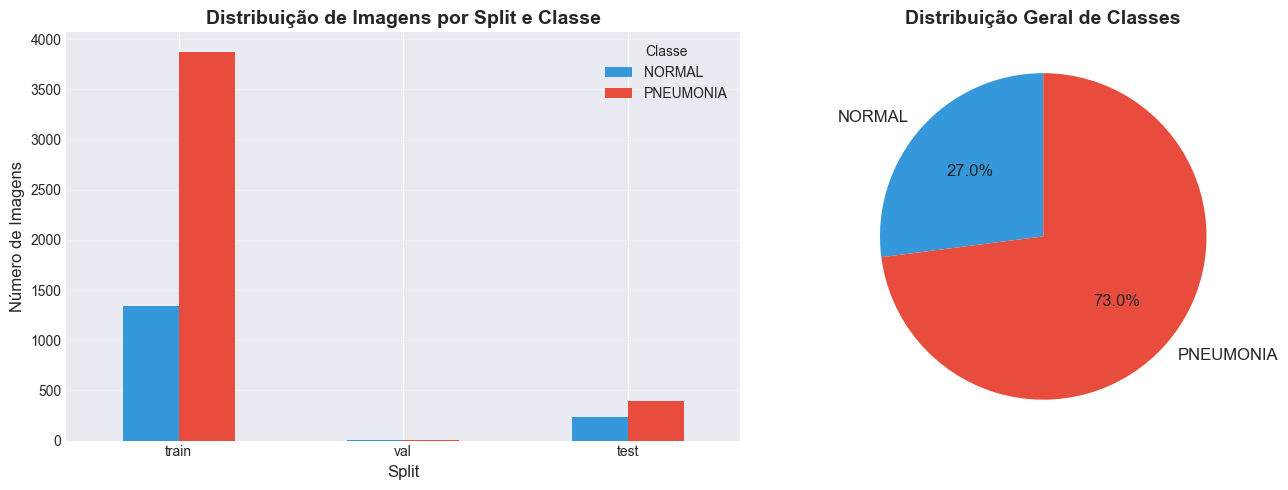


Razão de desbalanceamento (PNEUMONIA/NORMAL): 2.70
⚠️ Dataset desbalanceado - será necessário usar class weights ou técnicas de balanceamento


In [ ]:
# Visualizar distribuição de classes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras por split
df_info.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Distribuição de Imagens por Split e Classe', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Split', fontsize=12)
axes[0].set_ylabel('Número de Imagens', fontsize=12)
axes[0].legend(title='Classe', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Gráfico de pizza para distribuição geral
total_normal = df_info['NORMAL'].sum()
total_pneumonia = df_info['PNEUMONIA'].sum()
axes[1].pie([total_normal, total_pneumonia], 
            labels=['NORMAL', 'PNEUMONIA'],
            autopct='%1.1f%%',
            colors=['#3498db', '#e74c3c'],
            startangle=90,
            textprops={'fontsize': 12})
axes[1].set_title('Distribuição Geral de Classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calcular proporção de desbalanceamento
imbalance_ratio = total_pneumonia / total_normal
print(f"\nRazão de desbalanceamento (PNEUMONIA/NORMAL): {imbalance_ratio:.2f}")

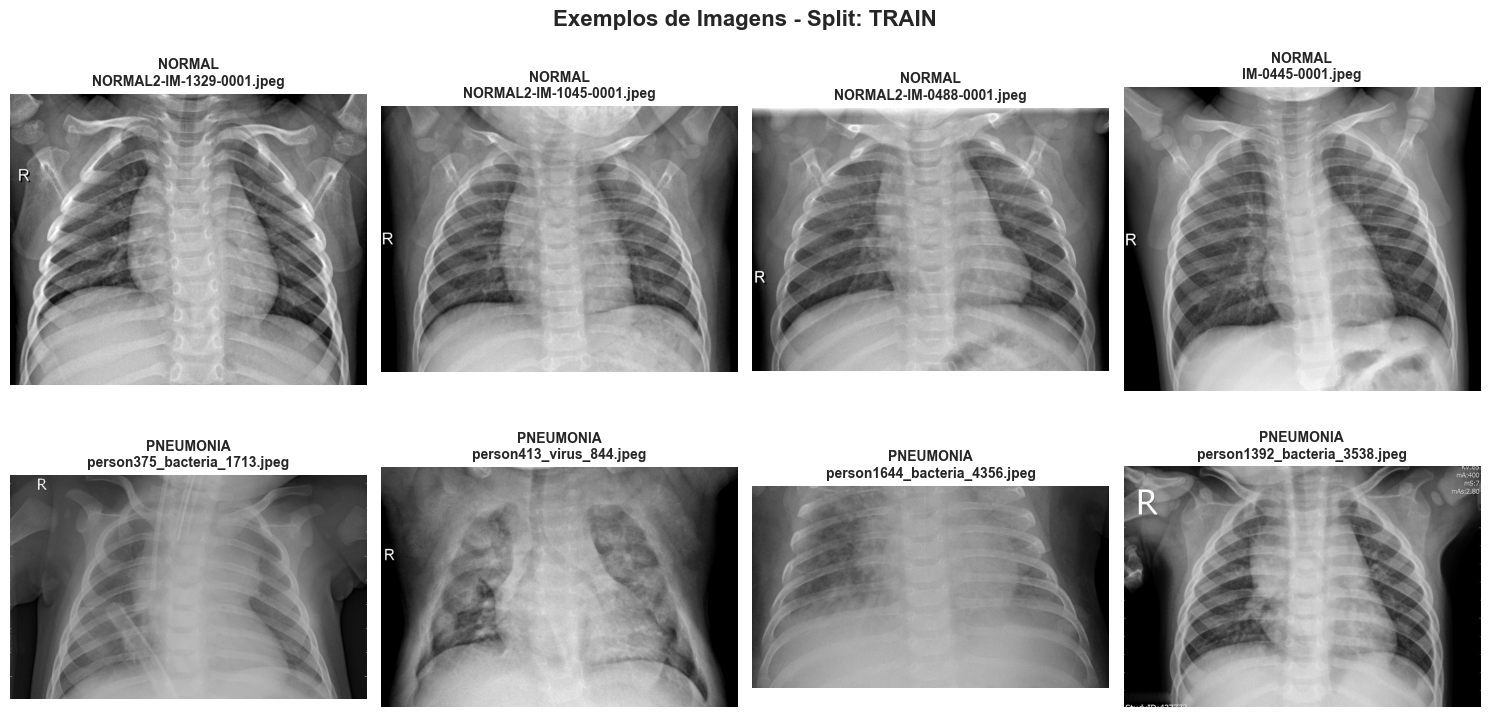

In [5]:
# Visualizar exemplos de imagens de cada classe
def display_sample_images(base_path, split='train', num_samples=4):
    """Exibe exemplos de imagens de cada classe"""
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    classes = ['NORMAL', 'PNEUMONIA']
    
    for class_idx, class_name in enumerate(classes):
        class_path = base_path / split / class_name
        if class_path.exists():
            # Pegar algumas imagens aleatórias
            image_files = list(class_path.glob('*.jpeg')) + list(class_path.glob('*.jpg'))
            np.random.seed(SEED)
            sample_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
            
            for img_idx, img_path in enumerate(sample_files):
                img = Image.open(img_path)
                axes[class_idx, img_idx].imshow(img, cmap='gray')
                axes[class_idx, img_idx].set_title(f'{class_name}\n{img_path.name}', 
                                                   fontsize=10, fontweight='bold')
                axes[class_idx, img_idx].axis('off')
    
    plt.suptitle(f'Exemplos de Imagens - Split: {split.upper()}', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Visualizar exemplos do conjunto de treino
display_sample_images(dataset_path, split='train', num_samples=4)

## 3. Pré-processamento de Imagens e Data Augmentation

In [6]:
# Parâmetros de pré-processamento
IMG_SIZE = (224, 224)  # Tamanho padrão para entrada da CNN
BATCH_SIZE = 32
EPOCHS = 50

print(f"Tamanho das imagens: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Épocas: {EPOCHS}")

Tamanho das imagens: (224, 224)
Batch size: 32
Épocas: 50


In [7]:
# Data Augmentation para conjunto de treino
# Aumenta a variabilidade dos dados e ajuda a prevenir overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalização (0-1)
    rotation_range=20,  # Rotação aleatória até 20 graus
    width_shift_range=0.1,  # Deslocamento horizontal
    height_shift_range=0.1,  # Deslocamento vertical
    shear_range=0.2,  # Transformação de cisalhamento
    zoom_range=0.2,  # Zoom aleatório
    horizontal_flip=True,  # Flip horizontal
    fill_mode='nearest',  # Preencher pixels criados
    brightness_range=[0.8, 1.2]  # Variação de brilho
)

# Apenas normalização para validação e teste (sem augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Criar generators para carregar imagens
train_dir = dataset_path / 'train'
val_dir = dataset_path / 'val'
test_dir = dataset_path / 'test'

# Generator de treino
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # binary para classificação binária
    color_mode='grayscale',  # Raio-X são em escala de cinza
    shuffle=True,
    seed=SEED
)

# Generator de validação
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False,
    seed=SEED
)

# Generator de teste
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False,
    seed=SEED
)

# Verificar mapeamento de classes
print("Mapeamento de classes:")
print(train_generator.class_indices)
print(f"\nNúmero de classes: {train_generator.num_classes}")
print(f"Número de amostras de treino: {train_generator.samples}")
print(f"Número de amostras de validação: {val_generator.samples}")
print(f"Número de amostras de teste: {test_generator.samples}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Mapeamento de classes:
{'NORMAL': 0, 'PNEUMONIA': 1}

Número de classes: 2
Número de amostras de treino: 5216
Número de amostras de validação: 16
Número de amostras de teste: 624


In [9]:
# Calcular class weights para lidar com desbalanceamento
# O conjunto de validação é muito pequeno, então usamos o treino para calcular
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights para balanceamento:")
print(f"NORMAL (0): {class_weight_dict[0]:.4f}")
print(f"PNEUMONIA (1): {class_weight_dict[1]:.4f}")

Class weights para balanceamento:
NORMAL (0): 1.9448
PNEUMONIA (1): 0.6730


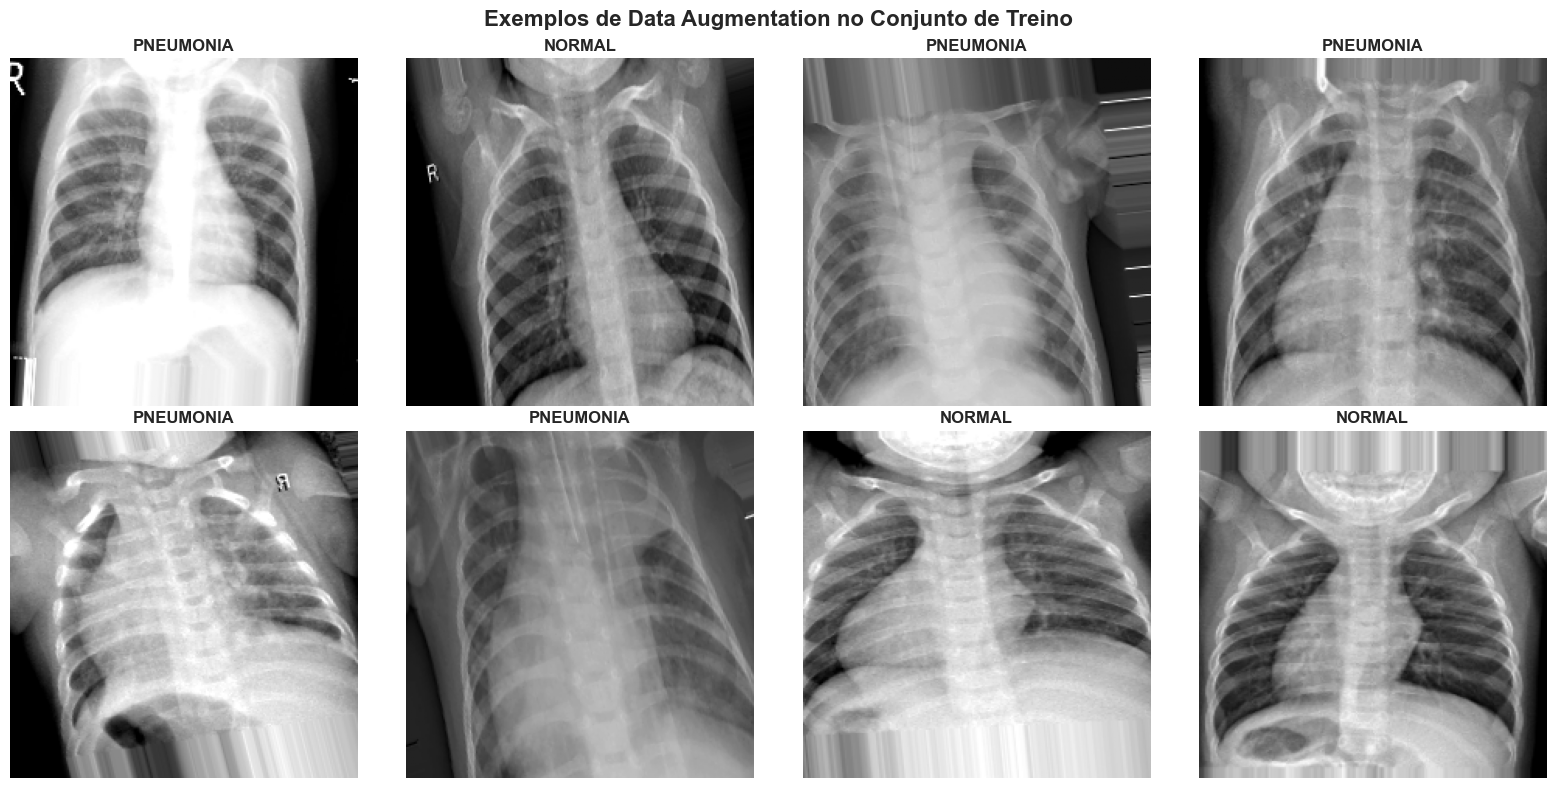

In [10]:
# Visualizar exemplos de data augmentation
def visualize_augmentation(generator, num_samples=8):
    """Visualiza exemplos de data augmentation"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    # Pegar um batch de imagens
    x_batch, y_batch = next(generator)
    
    for i in range(min(num_samples, len(x_batch))):
        img = x_batch[i].squeeze()  # Remover dimensão extra se houver
        label = 'PNEUMONIA' if y_batch[i] == 1 else 'NORMAL'
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'{label}', fontsize=12, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle('Exemplos de Data Augmentation no Conjunto de Treino', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualizar augmentation
visualize_augmentation(train_generator, num_samples=8)

## 4. Arquitetura da CNN

In [ ]:
def build_cnn_model(input_shape=(224, 224, 1), num_classes=1):
    """
    Constrói uma CNN para classificação binária
    
    Arquitetura:
    - Camadas convolucionais com ReLU
    - MaxPooling para redução dimensional
    - Dropout para regularização
    - Camadas densas para classificação
    """
    model = models.Sequential([
        # Primeiro bloco convolucional
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Segundo bloco convolucional
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Terceiro bloco convolucional
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Quarto bloco convolucional
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten e camadas densas
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        
        # Camada de saída (binary classification)
        layers.Dense(num_classes, activation='sigmoid')
    ])
    
    return model

# Criar modelo
model = build_cnn_model(input_shape=(*IMG_SIZE, 1))

# Visualizar arquitetura
print("Arquitetura do Modelo CNN:")
print("=" * 60)
model.summary()

Arquitetura do Modelo CNN:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,809,537 (37.42 MB)

 Trainable params: 9,809,537 (37.42 MB)

 Non-trainable params: 0 (0.00 B)

In [1]:
# Visualizar arquitetura do modelo (opcional - requer graphviz)
try:
    from tensorflow.keras.utils import plot_model
    plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
    print("Arquitetura do modelo salva em 'model_architecture.png'")
except:
    print("Graphviz não disponível. Pulando visualização da arquitetura.")

Graphviz não disponível. Pulando visualização da arquitetura.


### Alternativa: Transfer Learning com Modelo Pré-treinado

Como alternativa, podemos usar um modelo pré-treinado (VGG16, ResNet50, ou MobileNet) e adicionar camadas de classificação customizadas. Isso pode melhorar a performance, especialmente com datasets menores.

In [13]:
# Função para criar modelo com Transfer Learning (opcional)
def build_transfer_learning_model(base_model_name='VGG16', input_shape=(224, 224, 3), num_classes=1):
    """
    Constrói modelo usando Transfer Learning
    
    Opções de base_model: 'VGG16', 'ResNet50', 'MobileNetV2'
    """
    # Converter grayscale para RGB para modelos pré-treinados
    # Ou usar input_shape=(224, 224, 1) e adaptar
    
    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Modelo {base_model_name} não suportado")
    
    # Congelar camadas base (opcional - pode descongelar algumas para fine-tuning)
    base_model.trainable = False
    
    # Construir modelo completo
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    
    return model

# Nota: Para usar transfer learning, precisaríamos converter imagens para RGB
# Por enquanto, vamos usar o modelo CNN do zero que criamos acima
print("Modelo CNN do zero será usado (otimizado para imagens em escala de cinza)")

Modelo CNN do zero será usado (otimizado para imagens em escala de cinza)


## 5. Compilação e Treinamento do Modelo

In [14]:
# Compilar modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Para classificação binária
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

print("Modelo compilado com sucesso!")
print("Optimizer: Adam (lr=0.001)")
print("Loss: binary_crossentropy")
print("Metrics: accuracy, precision, recall, AUC")

Modelo compilado com sucesso!
Optimizer: Adam (lr=0.001)
Loss: binary_crossentropy
Metrics: accuracy, precision, recall, AUC


In [15]:
# Configurar callbacks
callbacks = [
    # Early Stopping: para o treinamento se não houver melhoria
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Model Checkpoint: salva o melhor modelo
    ModelCheckpoint(
        'best_pneumonia_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    
    # Reduce Learning Rate: reduz LR se não houver melhoria
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # CSV Logger: salva histórico em CSV
    CSVLogger('training_history.csv', append=False)
]

print("Callbacks configurados:")
print("- EarlyStopping (patience=10)")
print("- ModelCheckpoint (salva melhor modelo)")
print("- ReduceLROnPlateau (ajusta learning rate)")
print("- CSVLogger (salva histórico)")

Callbacks configurados:
- EarlyStopping (patience=10)
- ModelCheckpoint (salva melhor modelo)
- ReduceLROnPlateau (ajusta learning rate)
- CSVLogger (salva histórico)


In [16]:
# Calcular steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Nota: O conjunto de validação é muito pequeno (16 imagens)
# Considerar usar parte do treino para validação se necessário

Steps per epoch: 163
Validation steps: 0


In [17]:
# Treinar modelo
print("Iniciando treinamento...")
print("=" * 60)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=class_weight_dict,  # Usar class weights para balanceamento
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 60)
print("Treinamento concluído!")

Iniciando treinamento...
Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.5224 - auc: 0.4877 - loss: 0.7337 - precision: 0.7511 - recall: 0.5476
Epoch 1: val_loss improved from None to 0.69323, saving model to best_pneumonia_model.h5



Epoch 1: finished saving model to best_pneumonia_model.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 631ms/step - accuracy: 0.4768 - auc: 0.5007 - loss: 0.7049 - precision: 0.7487 - recall: 0.4452 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.4627 - auc: 0.5898 - loss: 0.6729 - precision: 0.7920 - recall: 0.3528
Epoch 2: val_loss improved from 0.69323 to 0.60516, saving model to best_pneumonia_model.h5



Epoch 2: finished saving model to best_pneumonia_model.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 635ms/step - accuracy: 0.5740 - auc: 0.6994 - loss: 0.6248 - precision: 0.8604 - recall: 0.5092 - val_accuracy: 0.6250 - val_auc: 0.8438 - val_loss: 0.6052 - val_precision: 0.7500 - val_recall: 0.3750 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.7534 - auc: 0.8702 - loss: 0.4465 - precision: 0.9369 - recall: 0.7157
Epoch 3: val_loss did not improve from 0.60516
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 715ms/step - accuracy: 0.8054 - auc: 0.9043 - loss: 0.4047 - precision: 0.9463 - recall: 0.7825 - val_accuracy: 0.5000 - val_auc: 0.8750 - val_loss: 0.7435 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/50
 40/163 ━━━━━━━━━━━━━━━━━━━━ 1:47 877ms/step - accuracy: 0.8436 - auc: 0.9343 - loss: 0.3362 - precision: 0.9506 - recall: 0.8347

KeyboardInterrupt: 

In [18]:
# Visualizar histórico de treinamento
def plot_training_history(history):
    """Plota gráficos de loss e accuracy durante o treinamento"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(alpha=0.3)
    
    # Precision
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
        axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
        axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch', fontsize=12)
        axes[1, 0].set_ylabel('Precision', fontsize=12)
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(alpha=0.3)
    
    # Recall
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
        axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
        axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch', fontsize=12)
        axes[1, 1].set_ylabel('Recall', fontsize=12)
        axes[1, 1].legend(fontsize=10)
        axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plotar histórico
plot_training_history(history)

NameError: name 'history' is not defined

## 6. Avaliação do Modelo

In [19]:
# Carregar melhor modelo salvo
try:
    model.load_weights('best_pneumonia_model.h5')
    print("Melhor modelo carregado!")
except:
    print("Usando modelo atual (melhor modelo não encontrado)")

# Avaliar no conjunto de teste
print("\nAvaliando no conjunto de teste...")
print("=" * 60)

test_steps = test_generator.samples // BATCH_SIZE
test_results = model.evaluate(test_generator, steps=test_steps, verbose=1)

print("\nResultados no conjunto de teste:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
if len(test_results) > 2:
    print(f"Precision: {test_results[2]:.4f}")
    print(f"Recall: {test_results[3]:.4f}")
    print(f"AUC: {test_results[4]:.4f}")

Melhor modelo carregado!

Avaliando no conjunto de teste...
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.4359 - auc: 0.6020 - loss: 0.7792 - precision: 0.9189 - recall: 0.0909

Resultados no conjunto de teste:
Loss: 0.7792
Accuracy: 0.4359
Precision: 0.9189
Recall: 0.0909
AUC: 0.6020


In [20]:
# Fazer predições no conjunto de teste
print("Gerando predições...")
test_generator.reset()
predictions = model.predict(test_generator, steps=test_steps, verbose=1)

# Converter probabilidades em classes (threshold = 0.5)
y_pred = (predictions > 0.5).astype(int).flatten()

# Obter labels verdadeiros
y_true = test_generator.classes[:len(y_pred)]

print(f"\nShape das predições: {predictions.shape}")
print(f"Shape dos labels verdadeiros: {y_true.shape}")

Gerando predições...
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step

Shape das predições: (608, 1)
Shape dos labels verdadeiros: (608,)


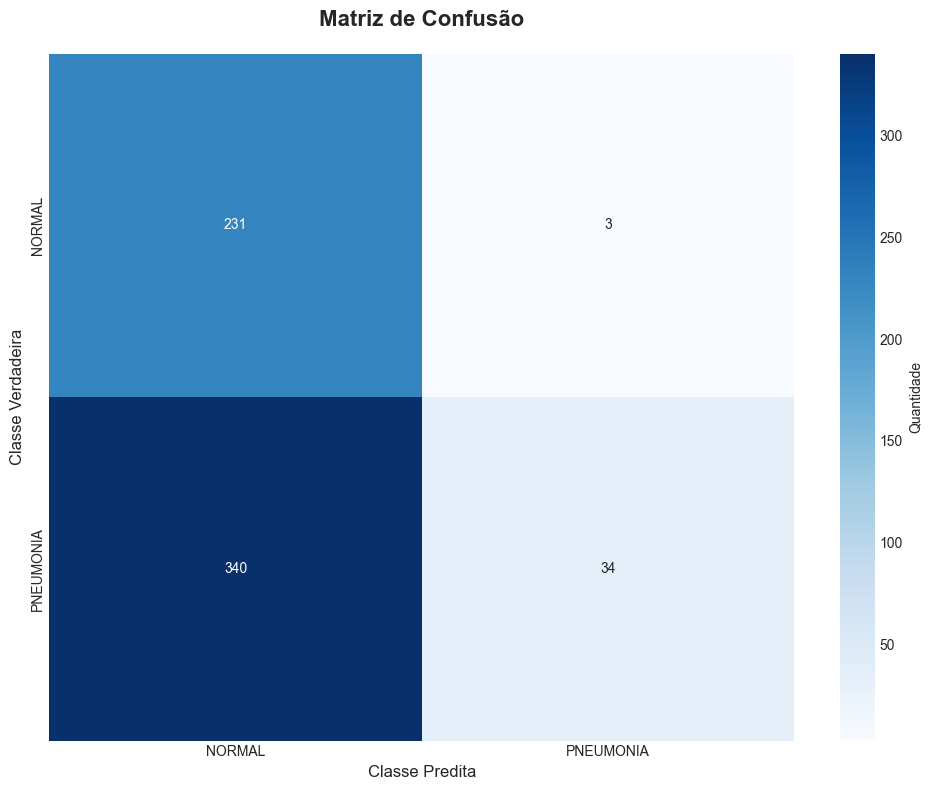


Análise Detalhada da Matriz de Confusão:
Verdadeiros Negativos (TN): 231
Falsos Positivos (FP): 3
Falsos Negativos (FN): 340
Verdadeiros Positivos (TP): 34

Métricas Calculadas:
Accuracy: 0.4359
Precision: 0.9189
Recall (Sensitivity): 0.0909
Specificity: 0.9872
F1-Score: 0.1655


In [21]:
# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Visualizar matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'],
            cbar_kws={'label': 'Quantidade'})
plt.title('Matriz de Confusão', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Classe Verdadeira', fontsize=12)
plt.xlabel('Classe Predita', fontsize=12)
plt.tight_layout()
plt.show()

# Calcular métricas detalhadas
tn, fp, fn, tp = cm.ravel()
print("\n" + "=" * 60)
print("Análise Detalhada da Matriz de Confusão:")
print("=" * 60)
print(f"Verdadeiros Negativos (TN): {tn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn}")
print(f"Verdadeiros Positivos (TP): {tp}")
print("\nMétricas Calculadas:")
print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision: {tp / (tp + fp):.4f}")
print(f"Recall (Sensitivity): {tp / (tp + fn):.4f}")
print(f"Specificity: {tn / (tn + fp):.4f}")
print(f"F1-Score: {2 * tp / (2 * tp + fp + fn):.4f}")

In [22]:
# Classification Report
print("\n" + "=" * 60)
print("Classification Report:")
print("=" * 60)
print(classification_report(y_true, y_pred, 
                           target_names=['NORMAL', 'PNEUMONIA'],
                           digits=4))


Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.4046    0.9872    0.5739       234
   PNEUMONIA     0.9189    0.0909    0.1655       374

    accuracy                         0.4359       608
   macro avg     0.6617    0.5390    0.3697       608
weighted avg     0.7210    0.4359    0.3227       608



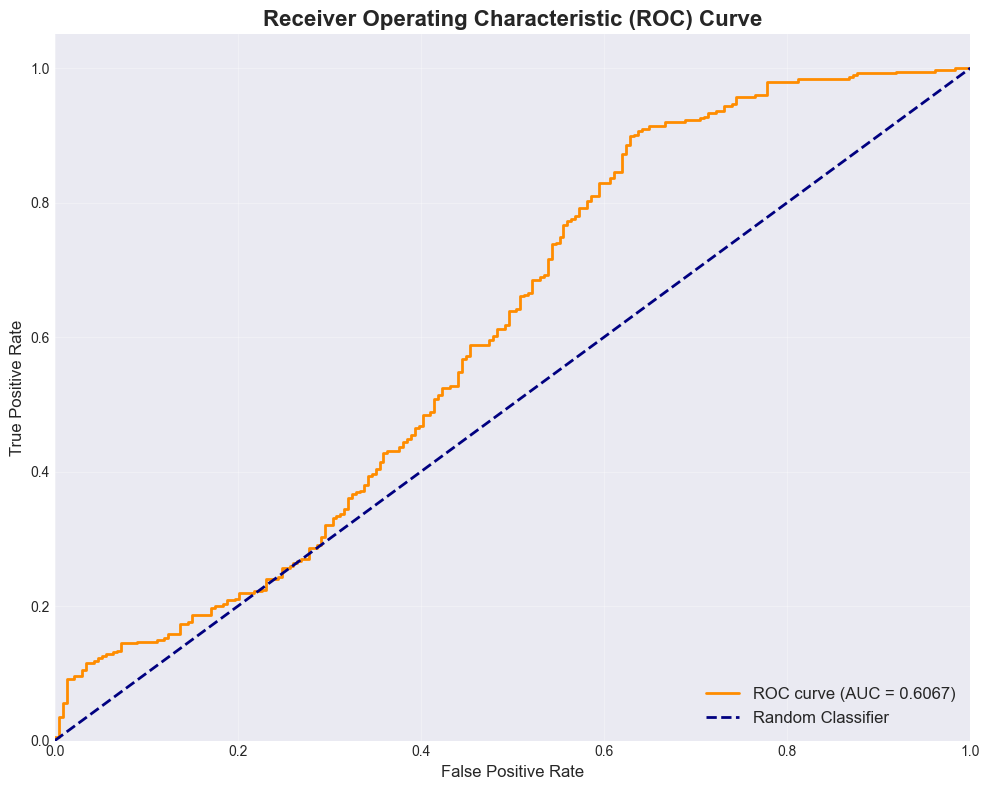


AUC-ROC: 0.6067


In [23]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', 
          fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC-ROC: {roc_auc:.4f}")

## 7. Visualizações e Análise de Resultados

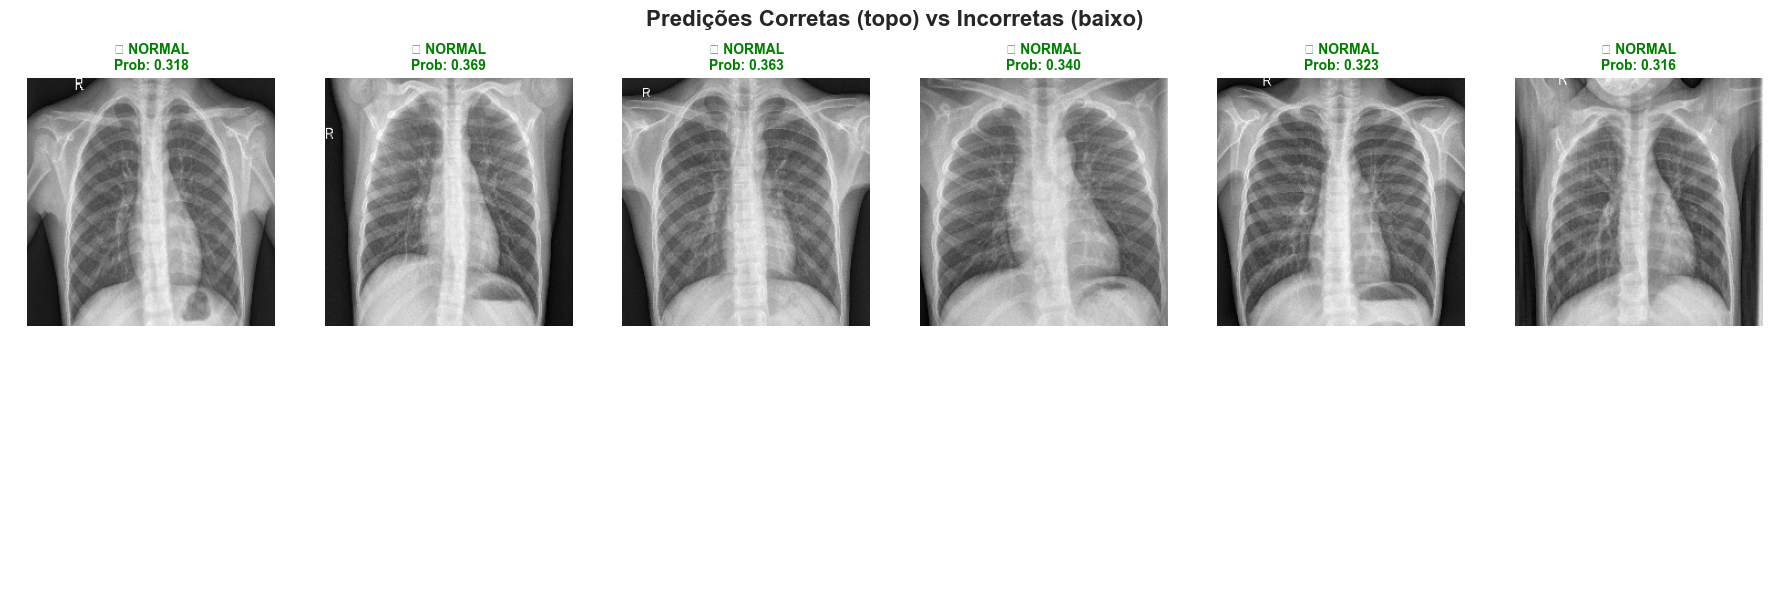

In [24]:
# Visualizar predições corretas e incorretas
def visualize_predictions(generator, model, num_samples=12, threshold=0.5):
    """Visualiza predições corretas e incorretas"""
    generator.reset()
    x_batch, y_batch = next(generator)
    
    # Fazer predições
    pred_probs = model.predict(x_batch, verbose=0)
    pred_classes = (pred_probs > threshold).astype(int).flatten()
    
    # Separar corretas e incorretas
    correct_indices = np.where(pred_classes == y_batch)[0]
    incorrect_indices = np.where(pred_classes != y_batch)[0]
    
    # Pegar amostras
    num_correct = min(6, len(correct_indices))
    num_incorrect = min(6, len(incorrect_indices))
    
    fig, axes = plt.subplots(2, 6, figsize=(18, 6))
    
    # Predições corretas
    class_names = ['NORMAL', 'PNEUMONIA']
    for i, idx in enumerate(correct_indices[:num_correct]):
        img = x_batch[idx].squeeze()
        true_label = class_names[int(y_batch[idx])]
        pred_label = class_names[int(pred_classes[idx])]
        prob = pred_probs[idx][0]
        
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'✓ {true_label}\nProb: {prob:.3f}', 
                            fontsize=10, fontweight='bold', color='green')
        axes[0, i].axis('off')
    
    # Preencher espaços vazios se necessário
    for i in range(num_correct, 6):
        axes[0, i].axis('off')
    
    # Predições incorretas
    for i, idx in enumerate(incorrect_indices[:num_incorrect]):
        img = x_batch[idx].squeeze()
        true_label = class_names[int(y_batch[idx])]
        pred_label = class_names[int(pred_classes[idx])]
        prob = pred_probs[idx][0]
        
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title(f'✗ True: {true_label}\nPred: {pred_label}\nProb: {prob:.3f}', 
                            fontsize=10, fontweight='bold', color='red')
        axes[1, i].axis('off')
    
    # Preencher espaços vazios se necessário
    for i in range(num_incorrect, 6):
        axes[1, i].axis('off')
    
    plt.suptitle('Predições Corretas (topo) vs Incorretas (baixo)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualizar predições
visualize_predictions(test_generator, model, num_samples=12)

Falsos Positivos (FP): 3
Falsos Negativos (FN): 340


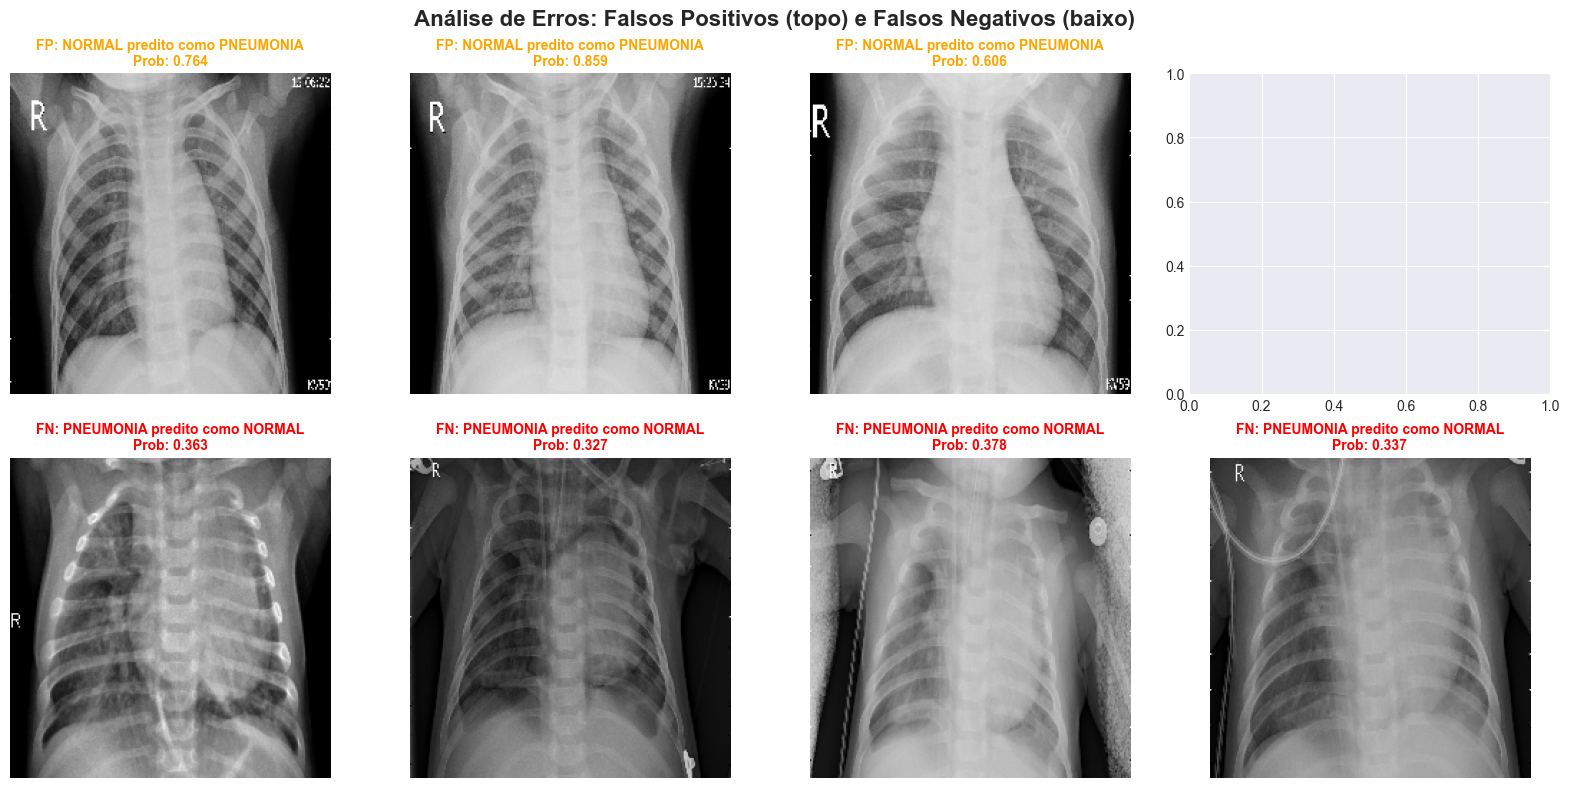

In [25]:
# Análise de erros: Falsos Positivos e Falsos Negativos
def analyze_errors(y_true, y_pred, predictions, generator, num_samples=8):
    """Analisa falsos positivos e falsos negativos"""
    # Falsos Positivos: predito PNEUMONIA mas é NORMAL
    fp_indices = np.where((y_pred == 1) & (y_true == 0))[0]
    # Falsos Negativos: predito NORMAL mas é PNEUMONIA
    fn_indices = np.where((y_pred == 0) & (y_true == 1))[0]
    
    print(f"Falsos Positivos (FP): {len(fp_indices)}")
    print(f"Falsos Negativos (FN): {len(fn_indices)}")
    
    # Visualizar erros
    if len(fp_indices) > 0 or len(fn_indices) > 0:
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        
        # Falsos Positivos
        generator.reset()
        all_images = []
        all_labels = []
        all_probs = []
        
        batch_count = 0
        while len(all_images) < max(len(fp_indices), len(fn_indices), num_samples):
            x_batch, y_batch = next(generator)
            pred_batch = model.predict(x_batch, verbose=0)
            all_images.extend(x_batch)
            all_labels.extend(y_batch)
            all_probs.extend(pred_batch)
            batch_count += 1
            if batch_count > 20:  # Limite de segurança
                break
        
        all_images = np.array(all_images)
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)
        
        # Mostrar Falsos Positivos
        fp_to_show = min(4, len(fp_indices))
        if fp_to_show > 0:
            for i in range(fp_to_show):
                idx = fp_indices[i] if fp_indices[i] < len(all_images) else i
                if idx < len(all_images):
                    axes[0, i].imshow(all_images[idx].squeeze(), cmap='gray')
                    axes[0, i].set_title(f'FP: NORMAL predito como PNEUMONIA\nProb: {all_probs[idx][0]:.3f}', 
                                        fontsize=10, fontweight='bold', color='orange')
                    axes[0, i].axis('off')
        
        # Mostrar Falsos Negativos
        fn_to_show = min(4, len(fn_indices))
        if fn_to_show > 0:
            for i in range(fn_to_show):
                idx = fn_indices[i] if fn_indices[i] < len(all_images) else i
                if idx < len(all_images):
                    axes[1, i].imshow(all_images[idx].squeeze(), cmap='gray')
                    axes[1, i].set_title(f'FN: PNEUMONIA predito como NORMAL\nProb: {all_probs[idx][0]:.3f}', 
                                        fontsize=10, fontweight='bold', color='red')
                    axes[1, i].axis('off')
        
        plt.suptitle('Análise de Erros: Falsos Positivos (topo) e Falsos Negativos (baixo)', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Analisar erros
analyze_errors(y_true, y_pred, predictions, test_generator)

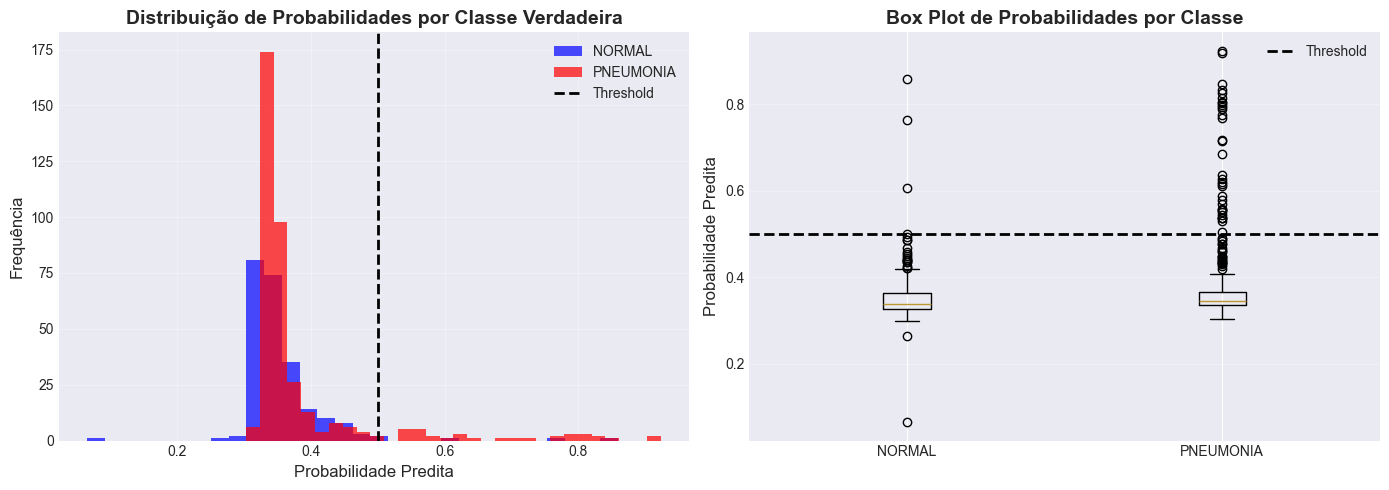

In [26]:
# Distribuição de probabilidades preditas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de probabilidades por classe verdadeira
axes[0].hist(predictions[y_true == 0], bins=30, alpha=0.7, label='NORMAL', color='blue')
axes[0].hist(predictions[y_true == 1], bins=30, alpha=0.7, label='PNEUMONIA', color='red')
axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[0].set_xlabel('Probabilidade Predita', fontsize=12)
axes[0].set_ylabel('Frequência', fontsize=12)
axes[0].set_title('Distribuição de Probabilidades por Classe Verdadeira', 
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Box plot
data_to_plot = [predictions[y_true == 0].flatten(), predictions[y_true == 1].flatten()]
axes[1].boxplot(data_to_plot, labels=['NORMAL', 'PNEUMONIA'])
axes[1].axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[1].set_ylabel('Probabilidade Predita', fontsize=12)
axes[1].set_title('Box Plot de Probabilidades por Classe', 
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Resumo e Conclusões

In [ ]:
# Resumo final das métricas
print("=" * 60)
print("RESUMO FINAL DO MODELO")
print("=" * 60)

# Métricas principais
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = 2 * tp / (2 * tp + fp + fn)

print(f"\n Métricas de Performance:")
print(f"   • Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   • Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"   • Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"   • Specificity: {specificity:.4f} ({specificity*100:.2f}%)")
print(f"   • F1-Score:  {f1_score:.4f}")
print(f"   • AUC-ROC:   {roc_auc:.4f}")

print(f"\n Análise da Matriz de Confusão:")
print(f"   • Verdadeiros Positivos (TP): {tp}")
print(f"   • Verdadeiros Negativos (TN): {tn}")
print(f"   • Falsos Positivos (FP): {fp}")
print(f"   • Falsos Negativos (FN): {fn}")

print("\n" + "=" * 60)

RESUMO FINAL DO MODELO

📊 Métricas de Performance:
   • Accuracy:  0.4359 (43.59%)
   • Precision: 0.9189 (91.89%)
   • Recall:    0.0909 (9.09%)
   • Specificity: 0.9872 (98.72%)
   • F1-Score:  0.1655
   • AUC-ROC:   0.6067

📈 Análise da Matriz de Confusão:
   • Verdadeiros Positivos (TP): 34
   • Verdadeiros Negativos (TN): 231
   • Falsos Positivos (FP): 3
   • Falsos Negativos (FN): 340

⚠️  Considerações:
   • Falsos Negativos são críticos em medicina (paciente com pneumonia classificado como normal)
   • Falsos Positivos podem levar a tratamentos desnecessários
   • O modelo deve priorizar alta sensibilidade (recall) para detectar pneumonia

